In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [2]:
# Constants
NUM_STATES = 19  # Number of non-terminal states
START_STATE = (NUM_STATES + 1) // 2  # Starting state (center state)
TERMINAL_LEFT = 0  # Left terminal state
TERMINAL_RIGHT = NUM_STATES + 1  # Right terminal state
MAX_EPISODES = 10  # Number of episodes per run
MAX_RUNS = 100  # Number of runs to average over
GAMMA = 1.0  # Discount factor
ALPHAS = np.arange(0, 1.05, 0.05)  # Alpha values from 0 to 1
NS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]  # Different n-step values
TRUE_VALUES = np.arange(-9, 10) / 10.0  # True state values from -0.9 to 0.9


In [3]:
class RandomWalkEnvironment:
    """
    Random Walk Environment for the n-step TD prediction task.
    """

    def __init__(self, num_states):
        self.num_states = num_states
        self.start_state = (num_states + 1) // 2  # Center state
        self.terminal_left = 0
        self.terminal_right = num_states + 1
        self.state = None

    def reset(self):
        """
        Resets the environment to the starting state.
        """
        self.state = self.start_state
        return self.state

    def step(self):
        """
        Takes a random action and returns the next state, reward, and done flag.

        Returns:
        next_state -- int, the next state
        reward -- float, the reward received
        done -- bool, whether the episode has terminated
        """
        action = np.random.choice([-1, 1])  # Move left or right
        next_state = self.state + action
        if next_state == self.terminal_right:
            reward = 1.0
            done = True
        elif next_state == self.terminal_left:
            reward = -1.0
            done = True
        else:
            reward = 0.0
            done = False
        self.state = next_state
        return next_state, reward, done


In [4]:
class NStepTDAgent:
    """
    Agent implementing n-step TD prediction.
    """

    def __init__(self, num_states, n, alpha, gamma):
        """
        Initializes the n-step TD agent.

        Parameters:
        num_states -- int, the number of non-terminal states
        n -- int, the number of steps in n-step TD
        alpha -- float, the step-size parameter
        gamma -- float, the discount factor
        """
        self.num_states = num_states
        self.n = n
        self.alpha = alpha
        self.gamma = gamma
        self.V = np.zeros(num_states)  # Value estimates for non-terminal states

    def reset(self):
        """
        Resets the agent's memory and parameters for a new episode.
        """
        self.state_buffer = []
        self.reward_buffer = []
        self.T = float('inf')  # Time when episode ends

    def update(self, tau):
        """
        Updates the value function based on time tau.

        Parameters:
        tau -- int, time whose state's estimate is being updated
        """
        if tau >= 0:
            G = 0.0
            # Calculate the n-step return
            t_end = min(tau + self.n, self.T)
            # Ensure t_end is an integer
            if t_end == float('inf'):
                t_end = tau + self.n
            else:
                t_end = int(t_end)
            for i in range(tau + 1, t_end + 1):
                idx = i % (self.n + 1)
                G += (self.gamma ** (i - tau - 1)) * self.reward_buffer[idx]
            if tau + self.n < self.T:
                idx = (tau + self.n) % (self.n + 1)
                next_state = self.state_buffer[idx]
                if next_state != TERMINAL_LEFT and next_state != TERMINAL_RIGHT:
                    G += (self.gamma ** self.n) * self.V[next_state - 1]
            state_tau = self.state_buffer[tau % (self.n + 1)]
            if state_tau != TERMINAL_LEFT and state_tau != TERMINAL_RIGHT:
                state_idx = state_tau - 1  # Adjust index for zero-based array
                # Update value function
                self.V[state_idx] += self.alpha * (G - self.V[state_idx])

    def run_episode(self, env):
        """
        Runs a single episode using n-step TD prediction.

        Parameters:
        env -- RandomWalkEnvironment instance
        """
        self.reset()
        state = env.reset()
        self.state_buffer = [state] + [0] * self.n
        self.reward_buffer = [0.0] * (self.n + 1)
        time = 0
        while True:
            if time < self.T:
                next_state, reward, done = env.step()
                idx = (time + 1) % (self.n + 1)
                self.state_buffer[idx] = next_state
                self.reward_buffer[idx] = reward
                if done:
                    self.T = time + 1
            tau = time - self.n + 1
            if tau >= 0:
                self.update(tau)
            if tau == self.T - 1:
                break
            time += 1


In [5]:
def run_single_experiment(n, alpha, true_values):
    """
    Runs a single experiment (run) for a given n and alpha.

    Parameters:
    n -- int, n-step TD parameter
    alpha -- float, learning rate
    true_values -- numpy array, true state values

    Returns:
    errors -- list of RMS errors over episodes
    """
    env = RandomWalkEnvironment(NUM_STATES)
    agent = NStepTDAgent(NUM_STATES, n, alpha, GAMMA)
    errors = []
    for episode in range(MAX_EPISODES):
        agent.run_episode(env)
        # Compute RMS error
        rms_error = np.sqrt(np.mean((agent.V - true_values) ** 2))
        errors.append(rms_error)
    return errors


Processing n = 1
Processing n = 2
Processing n = 4
Processing n = 8
Processing n = 16
Processing n = 32
Processing n = 64
Processing n = 128
Processing n = 256
Processing n = 512


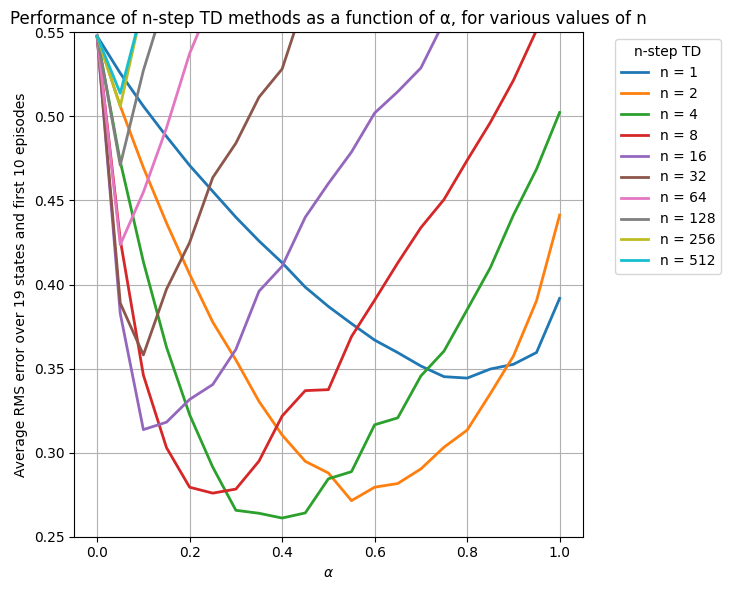

In [6]:
def main():
    """
    Main function to run the n-step TD prediction experiments and plot the results.
    """
    # Initialize error storage
    errors_alpha_n = np.zeros((len(NS), len(ALPHAS)))

    # Loop over different n-step values
    for n_idx, n in enumerate(NS):
        print(f"Processing n = {n}")
        # Loop over different alpha values
        for alpha_idx, alpha in enumerate(ALPHAS):
            # Use joblib to parallelize over runs
            results = Parallel(n_jobs=-1)(
                delayed(run_single_experiment)(n, alpha, TRUE_VALUES) for _ in range(MAX_RUNS)
            )
            # Average over runs and episodes
            average_error = np.mean([np.mean(run_errors) for run_errors in results])
            errors_alpha_n[n_idx, alpha_idx] = average_error

    # Plotting the results
    plt.figure(figsize=(10, 6))
    for n_idx, n in enumerate(NS):
        plt.plot(ALPHAS, errors_alpha_n[n_idx], label=f"n = {n}", linewidth=2)

    plt.xlabel(r'$\alpha$')
    plt.ylabel('Average RMS error over 19 states and first 10 episodes')
    plt.title('Performance of n-step TD methods as a function of α, for various values of n')
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.yticks(np.arange(0.25, 0.56, 0.05))
    plt.ylim(0.25, 0.55)  # Set y-axis limits
    plt.grid(True)

    # Place the legend outside the plot
    plt.legend(title='n-step TD', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make room for legend
    plt.show()


if __name__ == '__main__':
    main()
